+ [01 - NLP алгоритмы для мониторинга и AIOps с использованием библиотек Python](https://habr.com/ru/post/599513/)
+ [02 - NLP алгоритмы для мониторинга и AIOps с использованием библиотек Python](https://habr.com/ru/post/645395/)

## Дополнительные настройки

In [1]:
from pathlib import Path


PATH2ROOT = Path('')
PATH2RESULT = Path('result')

PATH2RESULT.mkdir(exist_ok=True)

## Предобработка текстовых данных для обучения моделей

In [13]:
import re
from nltk.tokenize.punkt import PunktSentenceTokenizer
sentTokenizer = PunktSentenceTokenizer()
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import langid
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from stop_words import get_stop_words

langid.set_languages(['en','ru'])
stopWordsEn=set().union(get_stop_words('en'), stopwords.words('english'))
stopWordsRu=set().union(get_stop_words('ru'), stopwords.words('russian'))
stopWords=list(set().union(stopWordsEn, stopWordsRu))
stopWords.sort()

textCollection=['The term language corpus is used to mean a number of rather different things. It may refer simply to any collection of linguistic data (for example, written, spoken, signed, or multimodal), although many practitioners prefer to reserve it for collections which have been organized or collected with a particular end in view, generally to characterize a particular state or variety of one or more languages. A text corpus is a large and unstructured set of texts (nowadays usually electronically stored and processed) used to do statistical analysis and hypothesis testing, checking occurrences or validating linguistic rules within a specific language territory.','Основные стадии предобработки текста включают в себя методы токенизации, методы нормализации и удаление стоп-слов.', 'Токенизация текста - это разбиение текста на текстовые единицы. В процессе токенизации текст сначала разбивается на предложения.', 'Tokenization in Python is the most primary step in any natural language processing program. ', 'We have imported re library and used "\w+" for picking up words from the expression.']

textCollTokens = []
for text in textCollection: ## loop over the collection  of texts
    sentList = [sent for sent in sentTokenizer.tokenize(text)]
    tokens = [word for sent in sentList for word in tokenizer.tokenize(sent.lower())]
    lemmedTokens=[]
    for token in tokens:
        if langid.classify(token)[0]=='en':
              lemmedTokens.append(lemmatizer.lemmatize(token))
        elif langid.classify(token)[0]=='ru':
              lemmedTokens.append(morph.parse(token)[0].normal_form)
    goodTokens = [token for token in lemmedTokens if not token in stopWords]
    textCollTokens.append(goodTokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/romankryvokhyzha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/romankryvokhyzha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Выделение n-грамм и составление словаря токенов

In [14]:
from gensim.models.phrases import Phrases, Phraser

bigrams = Phrases(textCollTokens, min_count=1, threshold=5) ## finding bigrams in the collection
trigrams = Phrases(bigrams[textCollTokens], min_count=2, threshold=5) ## finding trigrams
bigramPhraser = Phraser(bigrams) ## setting up parser for bigrams
trigramPhraser = Phraser(trigrams) ## parser for trigrams
docCollTexts=[]
for doc in textCollTokens:
    docCollTexts.append(trigramPhraser[bigramPhraser[doc]])

In [15]:
from gensim import corpora

textCollDictionary = corpora.Dictionary(docCollTexts)
textCollDictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=None)

In [16]:
bigramPhraser.save(str(PATH2RESULT / 'bigramPhraser.pkl'))
trigramPhraser.save(str(PATH2RESULT / 'trigramPhraser.pkl'))
textCollDictionary.save(str(PATH2RESULT / 'textCollDictionary.pkl'))
textCollDictionary.save_as_text(str(PATH2RESULT / 'textCollDictionary.txt'))

## Тематическое моделирование методом латентного размещения Дирихле ([LDA](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf))

```
В принципе, у алгоритма LDA не так много параметров настройки, главный из которых - число латентных тем и его надо определять заранее, причём выбор оптимального значения этого параметра весьма нетривиальная задача. В своей практике мы руководствуемся следующим простым правилом: берём размер словаря токенов построенного на заданном корпусе текстов и делим на число от 10 до 20 (среднее число слов в отдельной теме) - полученное значение передаётся на вход алгоритма LDA.
```

In [17]:
from gensim import models
import numpy as np

textCorpus = [textCollDictionary.doc2bow(doc) for doc in docCollTexts]


nTopics=4
ldamodel=models.ldamodel.LdaModel(textCorpus, id2word=textCollDictionary, num_topics=nTopics, passes=10)
ldamodel.save(str(PATH2RESULT / 'ldaModel'))


textTopicsMtx=np.zeros(shape=(len(textCorpus),nTopics),dtype=float)
for k in range(len(textCorpus)): ## make the matrix of docs to topic vectors
    for tpcId,tpcProb in ldamodel.get_document_topics(textCorpus[k]):
        textTopicsMtx[k,tpcId] = tpcProb

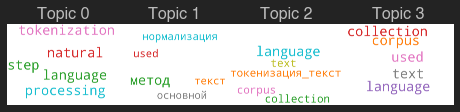

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(background_color='white', width=2500, height=1800, max_words=5, colormap='tab10', prefer_horizontal=1.0)
topics = ldamodel.show_topics(num_topics=nTopics, num_words=5, formatted=False)


fig, ax = plt.subplots(1, 4, figsize=(8, 3), sharex=True, sharey=True)
for i, ax in enumerate(ax.flatten()):
    fig.add_subplot(ax)
    topicWords = dict(topics[i][1])
    cloud.generate_from_frequencies(topicWords, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.show()

## Контекстное представление слов в моделях Word2Vec и Doc2Vec

In [19]:
from gensim.models import Doc2Vec

d2vSize = 5
d2vCorpus = [models.doc2vec.TaggedDocument(text,[k]) for k,text in enumerate(docCollTexts)]
d2vModel = Doc2Vec(vector_size=d2vSize, min_count=1, epochs=10, dm=1)
d2vModel.build_vocab(d2vCorpus)
d2vModel.train(d2vCorpus, total_examples=d2vModel.corpus_count, epochs=d2vModel.epochs)
d2vModel.save(str(PATH2RESULT / 'doc2vecModel'))

textD2vMtx = np.zeros(shape=(len(textCorpus), d2vSize),dtype=float)
for docId in range(len(d2vCorpus)):
    doc2vector = d2vModel.infer_vector(d2vCorpus[docId].words)
    textD2vMtx[docId,:] = doc2vector

## Кластеризация первичных событий ИТ-мониторинга

In [22]:
import hdbscan
import pickle
from sklearn import metrics

inpMtx=np.concatenate( (textTopicsMtx, textD2vMtx), axis=1)
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=4, prediction_data=True).fit(inpMtx) # training of the clusterization model

clusterLabels = hdb.labels_
nClusters = len(set(clusterLabels)) - (1 if -1 in clusterLabels else 0)
nNoise = list(clusterLabels).count(-1)
nEvents = inpMtx.shape[0]
noiseFraction=nNoise/nEvents
# silhouetteCoef=metrics.silhouette_score(inpMtx, clusterLabels)

with open(PATH2RESULT / 'clusterizationModel', 'wb') as fOut:
    pickle.dump(hdb,fOut,protocol=4)

```
где выходные значения noiseFraction - доля событий не попавших ни в один кластер, а silhouetteCoef (коэффициент силуэта) - мера усреднённой обособленности кластеров. Эти параметры можно использовать для оценки качества полученной модели кластеризации: каких-то четких общепринятых критериев нет, в своей практике мы используем модели с  noiseFraction<0.05 и silhouetteCoef>0.45.
```

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/umap/umap_.py:1382: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


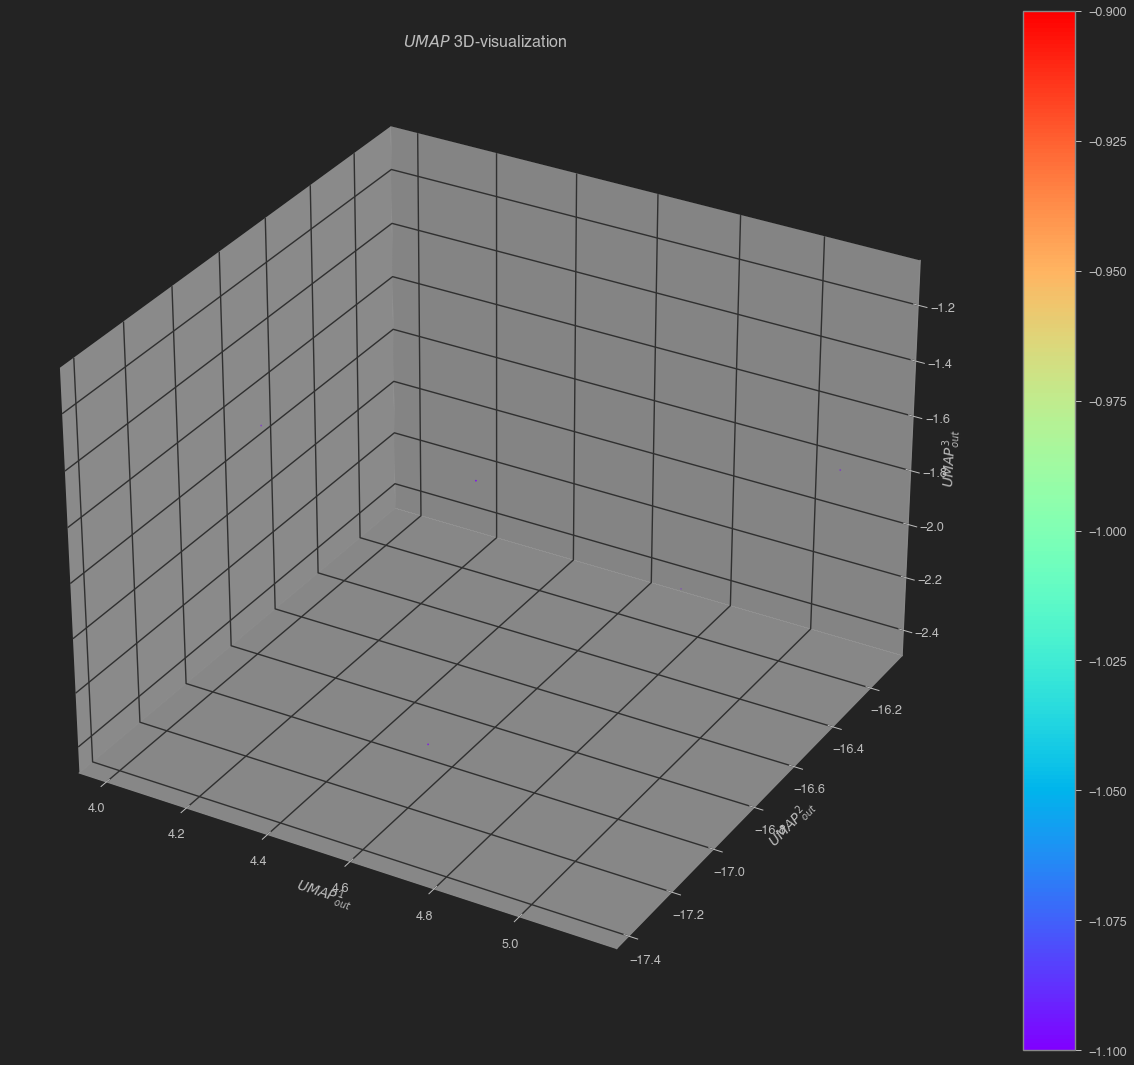

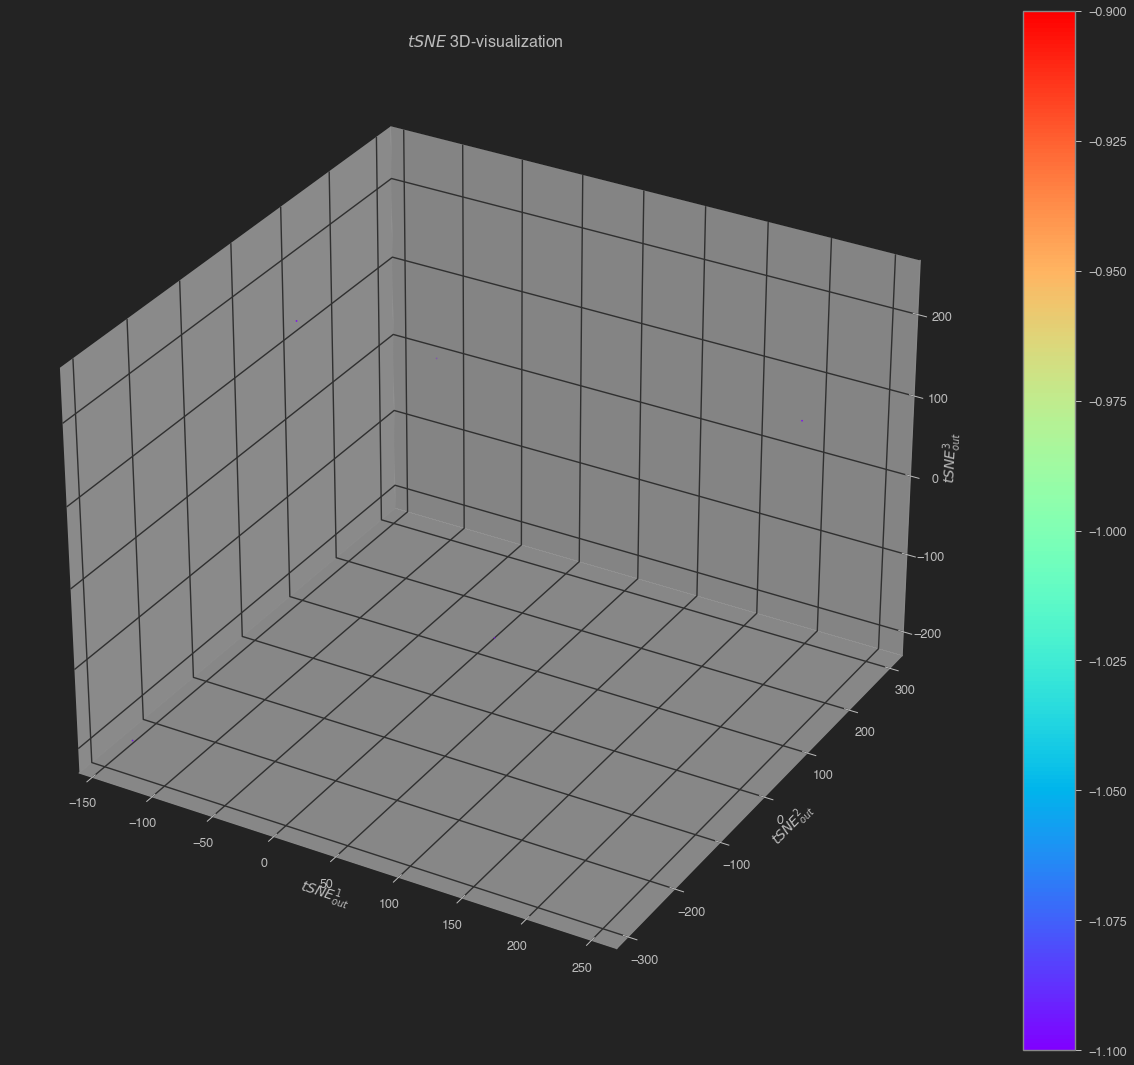

In [26]:
import matplotlib.pyplot as plt
from sklearn import manifold
import umap

pallet=plt.get_cmap('rainbow') # spectral, rainbow, terrain
nDim=3 
for alg in ['UMAP','tSNE']:
    if alg=='UMAP':
        reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=nDim, random_state=42)
        mapOut = reducer.fit_transform(inpMtx)
    elif alg=='tSNE':
        tsne = manifold.TSNE(n_components=nDim, init='random', random_state=42, perplexity=30, verbose=0)
        mapOut = tsne.fit_transform(inpMtx)
    figHdb = plt.figure(figsize=(17,15))
    axHdb = figHdb.add_subplot(111, projection='3d')
    axHdb.set_title(r'$'+alg+'$ 3D-visualization',fontsize=16)
    axHdb.set_xlabel(r'$'+alg+'_{out}^{1}$',fontsize=14)
    axHdb.set_ylabel(r'$'+alg+'_{out}^{2}$',fontsize=14)
    axHdb.set_zlabel(r'$'+alg+'_{out}^{3}$',fontsize=14)
    im3 = axHdb.scatter(mapOut[:,0], mapOut[:,1], mapOut[:,2], s=2, cmap=pallet, c=clusterLabels)
    figHdb.colorbar(im3, ax=axHdb)
    figHdb.tight_layout()
    figHdb.savefig(PATH2RESULT / (alg+'out_3D.png'))

In [25]:
mapOut

array([[-107.017815,  289.4402  ,   10.499694],
       [ 241.69417 ,  145.56491 ,  147.40143 ],
       [ -80.235916,  -65.95994 ,  233.74149 ],
       [  55.36285 ,   -7.841291, -127.52963 ],
       [-133.59836 , -281.97687 , -199.47989 ]], dtype=float32)